In [58]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely import box
import rioxarray 

In [59]:
path = "/home/simon/work/s5p-zarr-workflow/data/S5P_OFFL_L2__CO_____20240709T115918_20240709T134048_34917_03_020600_20240711T033528.nc.zip"
ds = xr.open_dataset(path, engine="netcdf4", group = "PRODUCT")

In [60]:
transformer = Transformer.from_crs("EPSG:27704", "EPSG:4326", always_xy=True)
x,y = 5700000, 2100000
lon_max, lat_max = transformer.transform(x, y)
x,y = 4200000, 900000
lon_min, lat_min = transformer.transform(x,y)

austria_bbox = box(lon_min, lat_min, lon_max, lat_max)

In [61]:
ds = ds.load()
ds = ds.set_coords(["longitude", "latitude"])
delta_time  = ds[["delta_time", "latitude", "longitude"]]

ds = ds.drop_vars(["delta_time", "time_utc" ])

In [62]:
mask = (
    (ds["latitude"] >= lat_min) & (ds["latitude"] <= lat_max) &
    (ds["longitude"] >= lon_min) & (ds["longitude"] <= lon_max) & 
    (ds["qa_value"] >= 0.5)
)

ds_subset = ds.where(mask, drop=True) 

In [63]:
ds_subset = ds_subset.rio.write_crs("EPSG:4326", inplace=False)

In [64]:
ds_band = ds_subset.squeeze()

In [65]:
lat_original = ds_band["latitude"]
lon_original = ds_band["longitude"]

In [66]:
lat_original

<xarray.DataArray 'latitude' (scanline: 267, ground_pixel: 62)> Size: 66kB
array([[39.95575 , 39.9656  , 39.975307, ..., 40.005363, 39.980377,
        39.95262 ],
       [40.00477 , 40.01462 , 40.02433 , ..., 40.053734, 40.02869 ,
        40.000874],
       [40.053787, 40.06364 , 40.073353, ..., 40.10211 , 40.077015,
        40.049137],
       ...,
       [52.852932, 52.863976, 52.874832, ..., 52.747097, 52.70599 ,
        52.66053 ],
       [52.9016  , 52.91265 , 52.923515, ..., 52.795288, 52.754116,
        52.70858 ],
       [52.95024 , 52.9613  , 52.972176, ..., 52.84343 , 52.802185,
        52.756573]], shape=(267, 62), dtype=float32)
Coordinates:
  * scanline      (scanline) float64 2kB 2.361e+03 2.362e+03 ... 2.627e+03
  * ground_pixel  (ground_pixel) float64 496B 153.0 154.0 155.0 ... 213.0 214.0
    time          datetime64[ns] 8B 2024-07-09
    latitude      (scanline, ground_pixel) float32 66kB 39.96 39.97 ... 52.76
    longitude     (scanline, ground_pixel) float32 66kB 5.783 5.885 ... 16.2
    spatial_ref   int64 8B 0
Attributes:
    long_name:      pixel center latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds

In [67]:
lat_min, lat_max = lat_original.min().item(), lat_original.max().item()
lon_min, lon_max = lon_original.min().item(), lon_original.max().item()
lat_min, lat_max, lon_min, lon_max

(39.95262145996094, 53.181461334228516, 1.7237330675125122, 17.13770866394043)

In [68]:
target_resolution = 0.1

n_points_lat_full = int(np.ceil((lat_max - lat_min) / target_resolution)) + 1
n_points_lon_full = int(np.ceil((lon_max - lon_min) / target_resolution)) + 1
target_lat_full = np.linspace(lat_min, lat_max, n_points_lat_full)
target_lon_full = np.linspace(lon_min, lon_max, n_points_lon_full)
lon_grid_full, lat_grid_full = np.meshgrid(target_lon_full, target_lat_full)

In [69]:
gridded_data = {}

for var in ds_band.data_vars:
    gridded = griddata((lon_original.values.flatten(), lat_original.values.flatten()),
                                    ds_band[var].values.flatten(),
                                    (lon_grid_full, lat_grid_full),
                                    method="linear")

    gridded_data[var] = gridded

In [70]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_numpy_to_equi7_eu_1km(
    data, lons, lats, nodata=np.nan, resampling="bilinear"
):

    assert data.ndim == 2 and data.shape == (len(lats), len(lons))

    if lats[0] < lats[-1]:
        data = data[::-1, :]
        lats = lats[::-1]

    xres = float(abs(lons[1] - lons[0]))
    yres = float(abs(lats[1] - lats[0]))
    west = float(lons.min())
    north = float(lats.max())
    src_transform = from_origin(west - xres/2, north + yres/2, xres, yres)
    src_crs = "EPSG:4326"

    dst_crs = "EPSG:27704"
    out_res = 10000.0

    left, bottom, right, top = rasterio.transform.array_bounds(
        data.shape[0], data.shape[1], src_transform
    )
    dst_transform, dst_w, dst_h = calculate_default_transform(
        src_crs, dst_crs, data.shape[1], data.shape[0],
        left, bottom, right, top, resolution=out_res
    )

    from math import floor
    x0 = floor(dst_transform.c / out_res) * out_res
    y0 = floor(dst_transform.f / out_res) * out_res
    dst_transform = rasterio.Affine(out_res, 0, x0, 0, -out_res, y0)

    dst = np.full((dst_h, dst_w), nodata, dtype=data.dtype)
    reproject(
        source=data,
        destination=dst,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=getattr(Resampling, resampling),
        src_nodata=nodata,
        dst_nodata=nodata,
    )
    return dst, dst_transform, dst_crs

In [71]:
reprojected = {}

for var in gridded_data:
    arr_10km, tr_1km, crs_1km = reproject_numpy_to_equi7_eu_1km(
        gridded_data[var], target_lon_full, target_lat_full,
        nodata=np.nan,                 # or np.nan for floats
        resampling="bilinear"          # use "nearest" for labels; "bilinear"/"cubic" for continuous
    )

    reprojected[var] = (("y", "x"),arr_10km)#.reshape(1,arr_10km.shape[0], arr_10km.shape[1]))

In [72]:
def pixel_center_coords(transform, width, height):
    """
    Returns 2D arrays X, Y with the projected coordinates
    of each pixel center given an affine transform.
    """
    # Column indices (0..width-1)
    cols = np.arange(width)
    # Row indices (0..height-1)
    rows = np.arange(height)

    # Convert pixel indices to map coords (center positions)
    xs = transform.c + cols * transform.a + transform.b * 0
    ys = transform.f + rows * transform.e + transform.d * 0

    # Meshgrid to 2D arrays
    #X, Y = np.meshgrid(xs, ys)
    return xs, ys

# Example usage after reprojection:
# arr_1km, tr_1km, crs_1km = reproject_numpy_to_equi7_eu_1km(...)
xs, ys = pixel_center_coords(tr_1km, arr_10km.shape[1], arr_10km.shape[0])

#print(X.shape, Y.shape)   # both (rows, cols)
#print(X.min(), X.max())   # extent in x
#print(Y.min(), Y.max())   # extent in y

In [73]:
sensing_time = delta_time["delta_time"].values.view("int64").mean().astype("datetime64[s]")

In [74]:
ds_equi7 = xr.Dataset(reprojected,
                      coords={
                                "x":("x", xs),
                              "y":("y", ys),
                              })

In [75]:
ds_aut = ds_equi7.sel(x=slice(4500000,5390000), y=slice(1790000,1200000))

In [76]:
transformer = Transformer.from_crs("EPSG:27704", "EPSG:4326", always_xy=True)
x,y = 5400000, 1800000
lon_max, lat_max = transformer.transform(x, y)
x,y = 4500000, 1200000
lon_min, lat_min = transformer.transform(x,y)

In [77]:
X, Y = np.meshgrid(xs, ys)
lons_new, lats_new = transformer.transform(X,Y)

In [78]:
ds_aut

<xarray.Dataset> Size: 170kB
Dimensions:                                (y: 60, x: 88)
Coordinates:
  * x                                      (x) float64 704B 4.5e+06 ... 5.37e+06
  * y                                      (y) float64 480B 1.79e+06 ... 1.2e+06
Data variables:
    qa_value                               (y, x) float64 42kB 0.7 0.7 ... nan
    carbonmonoxide_total_column            (y, x) float64 42kB 0.03027 ... nan
    carbonmonoxide_total_column_precision  (y, x) float64 42kB 0.001146 ... nan
    carbonmonoxide_total_column_corrected  (y, x) float64 42kB 0.02982 ... nan

In [79]:
ds_subset

<xarray.Dataset> Size: 400kB
Dimensions:                                (time: 1, scanline: 267,
                                            ground_pixel: 62, corner: 4,
                                            layer: 50)
Coordinates:
  * scanline                               (scanline) float64 2kB 2.361e+03 ....
  * ground_pixel                           (ground_pixel) float64 496B 153.0 ...
  * time                                   (time) datetime64[ns] 8B 2024-07-09
  * corner                                 (corner) float64 32B 0.0 1.0 2.0 3.0
  * layer                                  (layer) float32 200B 4.95e+04 ... ...
    latitude                               (time, scanline, ground_pixel) float32 66kB ...
    longitude                              (time, scanline, ground_pixel) float32 66kB ...
    spatial_ref                            int64 8B 0
Data variables:
    qa_value                               (time, scanline, ground_pixel) float32 66kB ...
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 66kB ...
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 66kB ...
    carbonmonoxide_total_column_corrected  (time, scanline, ground_pixel) float32 66kB ...

In [80]:
gridded_data

{'qa_value': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], shape=(134, 156)),
 'carbonmonoxide_total_column': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], shape=(134, 156)),
 'carbonmonoxide_total_column_precision': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], shape=(134, 156)),
 'carbo

/home/simon/.cache/pypoetry/virtualenvs/s5p-zarr-workflow-OUg_djUS-py3.11/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/simon/.cache/pypoetry/virtualenvs/s5p-zarr-workflow-OUg_djUS-py3.11/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


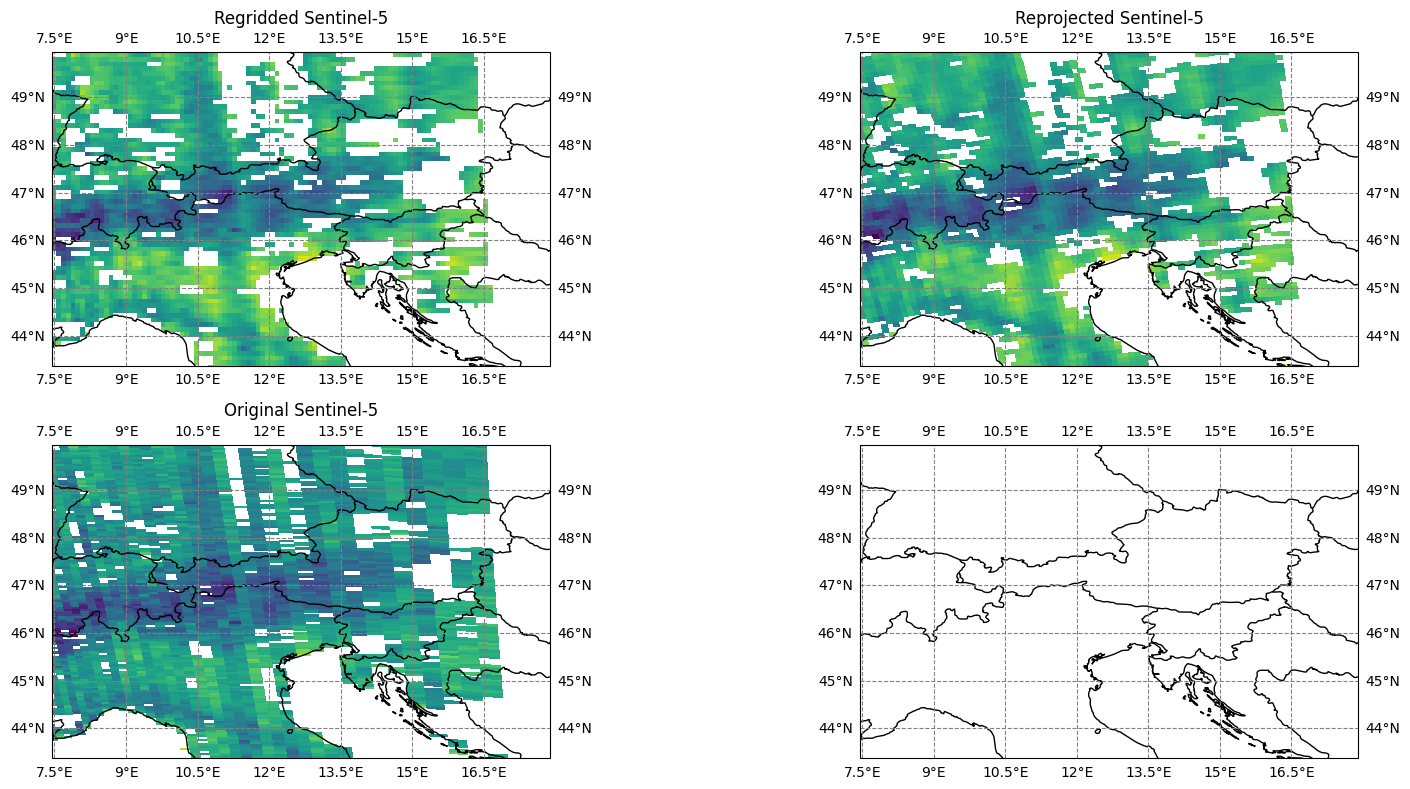

In [81]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17, 8), subplot_kw={"projection": ccrs.PlateCarree()})
axs=axs.flatten()
axs[0].pcolormesh(lon_grid_full, lat_grid_full, gridded_data["carbonmonoxide_total_column"], cmap="viridis")#, vmin=-2, vmax=1)
axs[1].pcolormesh(lons_new, lats_new, ds_equi7["carbonmonoxide_total_column"], transform=ccrs.PlateCarree(), cmap="viridis")#, vmin=-2, vmax=1)
axs[2].pcolormesh(lon_original, lat_original, ds_band["carbonmonoxide_total_column"], cmap="viridis")#, vmin=-2, vmax=1)

for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    
    ax.gridlines(draw_labels=True, color="gray", linestyle="--")
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)

axs[0].set_title("Regridded Sentinel-5")
axs[1].set_title("Reprojected Sentinel-5")
axs[2].set_title("Original Sentinel-5")

plt.tight_layout()
plt.show()

In [48]:
ds_aut

<xarray.Dataset> Size: 170kB
Dimensions:                                (y: 60, x: 88)
Coordinates:
  * x                                      (x) float64 704B 4.5e+06 ... 5.37e+06
  * y                                      (y) float64 480B 1.79e+06 ... 1.2e+06
Data variables:
    qa_value                               (y, x) float64 42kB 0.7 0.7 ... nan
    carbonmonoxide_total_column            (y, x) float64 42kB 0.03027 ... nan
    carbonmonoxide_total_column_precision  (y, x) float64 42kB 0.001146 ... nan
    carbonmonoxide_total_column_corrected  (y, x) float64 42kB 0.02982 ... nan